In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

from scipy.stats import uniform, randint
from BorutaShap import BorutaShap
import shap

from PIL import Image
import io
import csv 

In [2]:
def read_data(scenario):
    data_train = pd.read_csv(f'../data/{scenario}/train.csv')
    data_test = pd.read_csv(f'../data/{scenario}/test.csv')
    eta_col = 'ETA2'
    with open(f'../data/{scenario}/col_types.json') as f:
        col_types = json.load(f)
    return data_train, data_test, col_types

In [3]:
sc = 'reference'
data_train, data_test, col_types = read_data(sc)

In [4]:
X_train = data_train[[*col_types['cat'], *col_types['con']]]
y_train = data_train[col_types['eta']]
ids_train = data_train['ID']
studyids_train = data_train['STUDYID']


X_test = data_test[[*col_types['cat'], *col_types['con']]]
y_test = data_test[col_types['eta']]
ids_test = data_test['ID']
studyids_test = data_test['STUDYID']

In [5]:
param_dist = {
            'n_estimators': randint(5, 100),
            'max_depth': randint(1, 4), 
            'learning_rate': uniform(0.001, 0.1),
            'subsample': uniform(0.2, 0.8),  # this one when setting below 0.8, the r2 for xor scenario will be very small 
            'colsample_bytree': uniform(0.2, 0.4),
            'reg_alpha': uniform(0.2, 1.0),
            'reg_lambda': uniform(10, 30),
            'min_child_weight': randint(10, 20)
        }

# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor()

# Perform k-fold cross-validation and random search  # explained_variance better than r2
kf = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_reg, param_distributions=param_dist, 
                                   scoring='explained_variance', cv=kf, 
                                   verbose=1, n_iter=1000, n_jobs=-1, random_state=42)

# Fit the model with random search
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)
print("Best score:", random_search.best_score_)


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best Hyperparameters: {'colsample_bytree': 0.538048340598414, 'learning_rate': 0.08059263871435024, 'max_depth': 2, 'min_child_weight': 13, 'n_estimators': 93, 'reg_alpha': 0.22523734584826421, 'reg_lambda': 17.5793809186386, 'subsample': 0.6160592488889203}
Best score: 0.5547189338274027


In [6]:
# Train the model with the best hyperparameters on the full training set with early stopping # mae and rmse similar
best_xgb_reg = xgb.XGBRegressor(**best_params,  eval_metric="mae")  # eval_metric='rmsle',mape really bad results
# best_xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

best_xgb_reg.fit(X_train, y_train, verbose=False)

# Predict on training and testing sets
y_train_pred = best_xgb_reg.predict(X_train)
# y_val_pred = best_xgb_reg.predict(X_val)
y_test_pred = best_xgb_reg.predict(X_test)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
# val_mae = mean_absolute_error(y_val, y_val_pred)
# val_r2 = r2_score(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MAE:", train_mae)
print("Training R² Score:", train_r2)
# print("Validation MAE:", val_mae)
# print("Validation R² Score:", val_r2)
print("Testing MAE:", test_mae)
print("Testing R² Score:", test_r2)

Training MAE: 0.15156084299087524
Training R² Score: 0.6319654583930969
Testing MAE: 0.16473186016082764
Testing R² Score: 0.5982356071472168


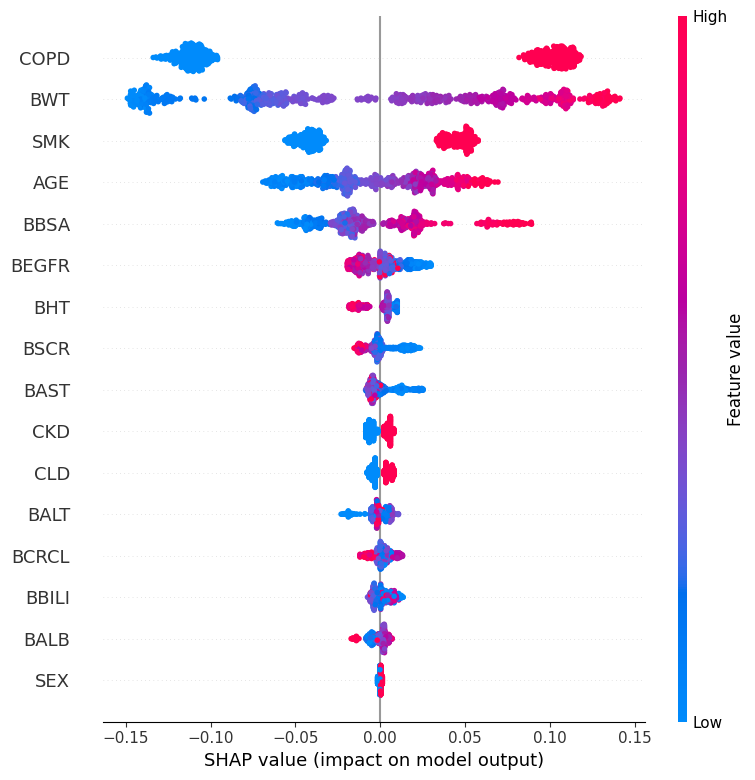

In [7]:
# Create a SHAP explainer
explainer = shap.Explainer(best_xgb_reg, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, show=True)



In [8]:


# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=best_xgb_reg,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=X_train, y=y_train, n_trials=1000, sample=False,train_or_test = 'test', normalize=True, verbose=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

5 attributes confirmed important: ['SMK', 'AGE', 'BBSA', 'BWT', 'COPD']
11 attributes confirmed unimportant: ['BCRCL', 'BEGFR', 'BSCR', 'BAST', 'BHT', 'SEX', 'BALB', 'CLD', 'BBILI', 'BALT', 'CKD']
0 tentative attributes remains: []


In [9]:
Feature_Selector.accepted

['SMK', 'AGE', 'BBSA', 'BWT', 'COPD']

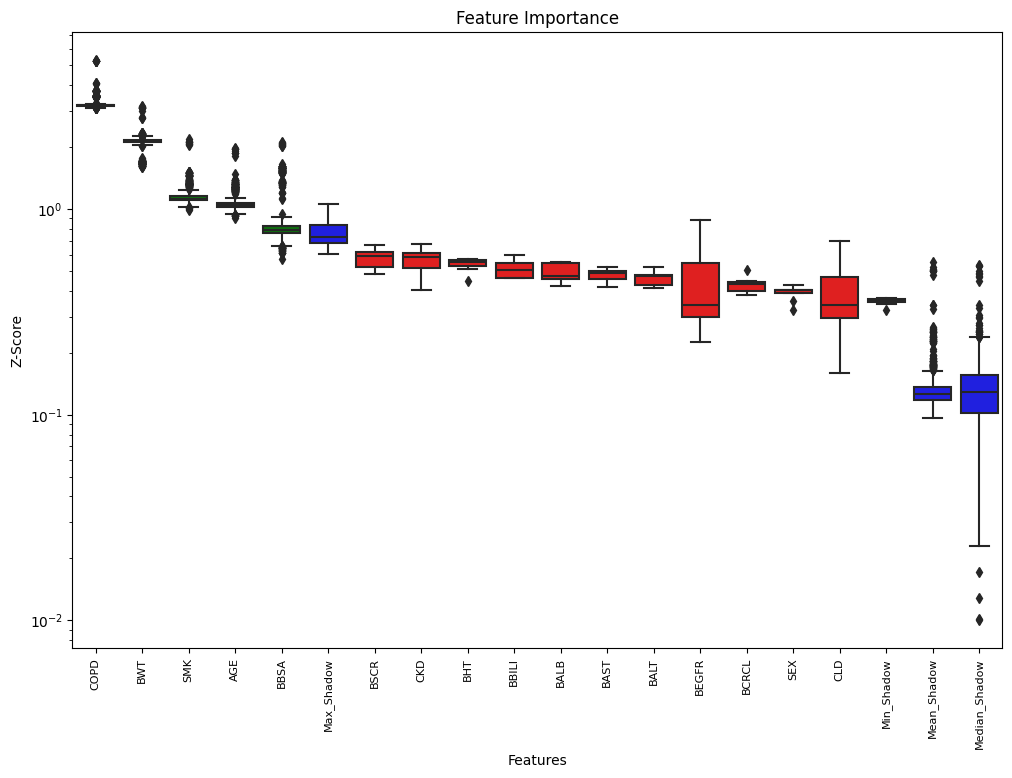

In [10]:
Feature_Selector.plot(which_features='all')